In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/deepglobe-land-cover-classification-dataset/class_dict.csv
/kaggle/input/deepglobe-land-cover-classification-dataset/metadata.csv
/kaggle/input/deepglobe-land-cover-classification-dataset/valid/8285_sat.jpg
/kaggle/input/deepglobe-land-cover-classification-dataset/valid/127801_sat.jpg
/kaggle/input/deepglobe-land-cover-classification-dataset/valid/198275_sat.jpg
/kaggle/input/deepglobe-land-cover-classification-dataset/valid/393509_sat.jpg
/kaggle/input/deepglobe-land-cover-classification-dataset/valid/262504_sat.jpg
/kaggle/input/deepglobe-land-cover-classification-dataset/valid/651633_sat.jpg
/kaggle/input/deepglobe-land-cover-classification-dataset/valid/392604_sat.jpg
/kaggle/input/deepglobe-land-cover-classification-dataset/valid/411176_sat.jpg
/kaggle/input/deepglobe-land-cover-classification-dataset/valid/808681_sat.jpg
/kaggle/input/deepglobe-land-cover-classification-dataset/valid/259219_sat.jpg
/kaggle/input/deepglobe-land-cover-classification-dataset/valid/6863

In [2]:
import pandas as pd
import numpy as np
import os
import torch
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from PIL import Image
import torch.nn as nn

# Define the class dictionary manually since the file is missing
class_data = {
    'name': ['urban_land', 'agriculture_land', 'rangeland', 'forest_land', 'water', 'barren_land', 'unknown'],
    'r': [0, 255, 255, 0, 0, 255, 0],
    'g': [255, 255, 0, 255, 0, 255, 0],
    'b': [255, 0, 255, 0, 255, 255, 0]
}
class_dict = pd.DataFrame(class_data)
print("Class Dictionary:")
print(class_dict)

# Define dataset paths
train_dir = '/kaggle/input/deepglobe-land-cover-classification-dataset/train'
val_dir = '/kaggle/input/deepglobe-land-cover-classification-dataset/valid'
test_dir = '/kaggle/input/deepglobe-land-cover-classification-dataset/test'

# Verify directories exist
for directory in [train_dir, val_dir, test_dir]:
    if os.path.exists(directory):
        print(f"{directory} exists with {len(os.listdir(directory))} files")
    else:
        print(f"Warning: {directory} does not exist")


Class Dictionary:
               name    r    g    b
0        urban_land    0  255  255
1  agriculture_land  255  255    0
2         rangeland  255    0  255
3       forest_land    0  255    0
4             water    0    0  255
5       barren_land  255  255  255
6           unknown    0    0    0
/kaggle/input/deepglobe-land-cover-classification-dataset/train exists with 1606 files
/kaggle/input/deepglobe-land-cover-classification-dataset/valid exists with 171 files
/kaggle/input/deepglobe-land-cover-classification-dataset/test exists with 172 files


In [3]:
class DeepGlobeDataset(Dataset):
    def __init__(self, img_dir, is_train=True, transform=None, size=(256, 256)):
        self.img_dir = img_dir
        self.is_train = is_train  # Training mode (expect masks) or inference mode
        self.transform = transform
        self.size = size
        self.class_rgb_values = [
            [0, 255, 255],     # urban_land 
            [255, 255, 0],     # agriculture_land
            [255, 0, 255],     # rangeland
            [0, 255, 0],       # forest_land
            [0, 0, 255],       # water
            [255, 255, 255],   # barren_land
            [0, 0, 0]          # unknown
        ]
        
        # Get all satellite image paths
        self.sat_images = [os.path.join(img_dir, f) for f in os.listdir(img_dir) 
                          if f.endswith('_sat.jpg')]
        
        # If training, filter to only include images with masks
        if self.is_train:
            valid_samples = []
            for img_path in self.sat_images:
                mask_path = img_path.replace('_sat.jpg', '_mask.png')
                if os.path.exists(mask_path):
                    valid_samples.append(img_path)
            self.sat_images = valid_samples
        
        print(f"Found {len(self.sat_images)} samples in {img_dir}")
    
    def __len__(self):
        return len(self.sat_images)
    
    def __getitem__(self, idx):
        # Load image
        img_path = self.sat_images[idx]
        
        with Image.open(img_path) as image:
            image = image.resize(self.size, Image.BILINEAR)
            image = np.array(image)
        
        # Convert image to tensor and normalize
        image = image.astype(np.float32) / 255.0
        image = torch.from_numpy(image).permute(2, 0, 1)
        
        # Standard normalization
        mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
        std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
        image = (image - mean) / std
        
        # For training mode, load and process mask
        if self.is_train:
            mask_path = img_path.replace('_sat.jpg', '_mask.png')
            with Image.open(mask_path) as mask:
                mask = mask.resize(self.size, Image.NEAREST)
                mask = np.array(mask)
            
            # Convert RGB mask to class indices
            mask_indices = torch.zeros(mask.shape[:2], dtype=torch.long)
            for class_idx, rgb in enumerate(self.class_rgb_values):
                r, g, b = rgb
                class_mask = (mask[:,:,0] == r) & (mask[:,:,1] == g) & (mask[:,:,2] == b)
                mask_indices[class_mask] = class_idx
            
            return image, mask_indices
        else:
            # For validation/test, return only the image
            return image, img_path


In [4]:
# Create datasets
train_dataset = DeepGlobeDataset(train_dir, is_train=True, size=(256, 256))
val_dataset = DeepGlobeDataset(val_dir, is_train=False, size=(256, 256))
test_dataset = DeepGlobeDataset(test_dir, is_train=False, size=(256, 256))

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False, num_workers=2)


Found 803 samples in /kaggle/input/deepglobe-land-cover-classification-dataset/train
Found 171 samples in /kaggle/input/deepglobe-land-cover-classification-dataset/valid
Found 172 samples in /kaggle/input/deepglobe-land-cover-classification-dataset/test


In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.checkpoint as checkpoint

class AttentionGate(nn.Module):
    def __init__(self, F_g, F_l, F_int):
        super().__init__()
        self.W_g = nn.Sequential(
            nn.Conv2d(F_g, F_int, kernel_size=1),
            nn.BatchNorm2d(F_int)
        )
        self.W_x = nn.Sequential(
            nn.Conv2d(F_l, F_int, kernel_size=1),
            nn.BatchNorm2d(F_int)
        )
        self.psi = nn.Sequential(
            nn.Conv2d(F_int, 1, kernel_size=1),
            nn.BatchNorm2d(1),
            nn.Sigmoid()
        )
        self.relu = nn.ReLU(inplace=True)

    def forward(self, g, x):
        g1 = self.W_g(g)
        x1 = self.W_x(x)
        psi = self.relu(g1 + x1)
        psi = self.psi(psi)
        return x * psi

class ConvBlock(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.conv(x)

class LightAttentionUNet(nn.Module):
    def __init__(self, img_ch=3, output_ch=7):
        super().__init__()
        
        # Reduced filter counts for memory efficiency
        # Encoder
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv1 = ConvBlock(img_ch, 32)  # Reduced from 64
        self.conv2 = ConvBlock(32, 64)      # Reduced from 128
        self.conv3 = ConvBlock(64, 128)     # Reduced from 256
        self.conv4 = ConvBlock(128, 256)    # Reduced from 512
        self.conv5 = ConvBlock(256, 512)    # Reduced from 1024
        
        # Attention gates with reduced dimensions
        self.attention1 = AttentionGate(F_g=256, F_l=256, F_int=128)
        self.attention2 = AttentionGate(F_g=128, F_l=128, F_int=64)
        self.attention3 = AttentionGate(F_g=64, F_l=64, F_int=32)
        self.attention4 = AttentionGate(F_g=32, F_l=32, F_int=16)
        
        # Decoder
        self.up5 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.up_conv5 = ConvBlock(512, 256)  # 256 + 256 input channels
        
        self.up4 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.up_conv4 = ConvBlock(256, 128)  # 128 + 128 input channels
        
        self.up3 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.up_conv3 = ConvBlock(128, 64)   # 64 + 64 input channels
        
        self.up2 = nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2)
        self.up_conv2 = ConvBlock(64, 32)    # 32 + 32 input channels
        
        # Output layer
        self.output = nn.Conv2d(32, output_ch, kernel_size=1)
        
        # Enable gradient checkpointing
        self.use_checkpointing = True

    def forward(self, x):
        # Encoding with optional checkpointing for memory efficiency
        if self.use_checkpointing and self.training:
            e1 = checkpoint.checkpoint(self.conv1, x, use_reentrant=False)
            e2 = checkpoint.checkpoint(self.conv2, self.maxpool(e1), use_reentrant=False)
            e3 = checkpoint.checkpoint(self.conv3, self.maxpool(e2), use_reentrant=False)
            e4 = checkpoint.checkpoint(self.conv4, self.maxpool(e3), use_reentrant=False)
            e5 = checkpoint.checkpoint(self.conv5, self.maxpool(e4), use_reentrant=False)
        else:
            e1 = self.conv1(x)
            e2 = self.conv2(self.maxpool(e1))
            e3 = self.conv3(self.maxpool(e2))
            e4 = self.conv4(self.maxpool(e3))
            e5 = self.conv5(self.maxpool(e4))
        
        # Decoding with attention
        d5 = self.up5(e5)
        a4 = self.attention1(g=d5, x=e4)
        d5 = torch.cat((a4, d5), dim=1)
        d5 = self.up_conv5(d5)
        
        d4 = self.up4(d5)
        a3 = self.attention2(g=d4, x=e3)
        d4 = torch.cat((a3, d4), dim=1)
        d4 = self.up_conv4(d4)
        
        d3 = self.up3(d4)
        a2 = self.attention3(g=d3, x=e2)
        d3 = torch.cat((a2, d3), dim=1)
        d3 = self.up_conv3(d3)
        
        d2 = self.up2(d3)
        a1 = self.attention4(g=d2, x=e1)
        d2 = torch.cat((a1, d2), dim=1)
        d2 = self.up_conv2(d2)
        
        output = self.output(d2)
        
        return output


In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initializing the model
model = LightAttentionUNet().to(device)

class DiceLoss(nn.Module):
    def __init__(self, weight=None, smooth=1.0):
        super(DiceLoss, self).__init__()
        self.weight = weight
        self.smooth = smooth
        self.classes_to_ignore = []
        
    def forward(self, inputs, targets):
        # Remove autocast to avoid warnings
        inputs = inputs.float()
        probs = F.softmax(inputs, dim=1)
        
        dice_scores = []
        n_classes = probs.shape[1]
        
        for cls in range(n_classes):
            if cls in self.classes_to_ignore:
                continue
                
            pred_cls = probs[:, cls, ...]
            target_cls = (targets == cls).float()
            
            pred_cls = pred_cls.contiguous().view(-1)
            target_cls = target_cls.contiguous().view(-1)
            
            intersection = (pred_cls * target_cls).sum()
            cardinality = pred_cls.sum() + target_cls.sum()
            
            dice = (2. * intersection + self.smooth) / (cardinality + self.smooth)
            
            if self.weight is not None and cls < len(self.weight):
                dice = dice * self.weight[cls]
                
            dice_scores.append(dice)
        
        if len(dice_scores) > 0:
            return 1 - torch.stack(dice_scores).mean()
        else:
            return torch.tensor(0.0, device=inputs.device, requires_grad=True)

class CombinedLoss(nn.Module):
    def __init__(self, ce_weight=1.0, dice_weight=1.0, class_weights=None):
        super(CombinedLoss, self).__init__()
        self.ce_weight = ce_weight
        self.dice_weight = dice_weight
        
        self.ce = nn.CrossEntropyLoss(weight=class_weights)
        self.dice = DiceLoss(weight=class_weights)
        
    def forward(self, inputs, targets):
        ce_loss = self.ce(inputs, targets)
        dice_loss = self.dice(inputs, targets)
        
        if torch.isnan(ce_loss) or torch.isnan(dice_loss):
            print(f"Warning: NaN detected in loss: CE={ce_loss}, Dice={dice_loss}")
            
        return self.ce_weight * ce_loss + self.dice_weight * dice_loss

# Class weights
class_weights = torch.tensor([2.0,    # Urban
                             0.8,     # Agriculture
                             1.5,     # Rangeland
                             1.2,     # Forest
                             3.0,     # Water
                             1.7,     # Barren
                             0.5],    # Unknown/background
                            device=device)

# Defining criterion and optimizer
criterion = CombinedLoss(ce_weight=1.0, dice_weight=1.0, class_weights=class_weights)
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

# Learning rate scheduler
scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(
    optimizer, 
    T_0=5,
    T_mult=2,
    eta_min=1e-6
)

print("Improved loss function and optimizer defined successfully")


Improved loss function and optimizer defined successfully


In [7]:
!pip install torch torchvision

In [ ]:
import torch
import time
from tqdm.auto import tqdm
import copy
import matplotlib.pyplot as plt

def calculate_metrics(outputs, targets):
    """Calculate accuracy and Dice score for segmentation"""
    # For multi-class segmentation
    predictions = torch.argmax(outputs, dim=1)
    
    # Ensure targets are in the correct format
    if targets.dim() == 4 and targets.shape[1] > 1:
        target_classes = torch.argmax(targets, dim=1)
    else:
        target_classes = targets
    
    # Calculate pixel accuracy
    correct = torch.eq(predictions, target_classes).float()
    accuracy = torch.mean(correct).item()
    
    # Calculate Dice coefficient
    dice_scores = []
    num_classes = outputs.shape[1]
    
    for cls in range(num_classes):
        pred_cls = (predictions == cls).float()
        target_cls = (target_classes == cls).float()
        
        intersection = torch.sum(pred_cls * target_cls)
        union = torch.sum(pred_cls) + torch.sum(target_cls)
        
        if union == 0:
            dice_scores.append(1.0)  # If class not present in both, score = 1
        else:
            dice = (2. * intersection + 1e-6) / (union + 1e-6)
            dice_scores.append(dice.item())
    
    mean_dice = sum(dice_scores) / len(dice_scores)
    return accuracy, mean_dice

def train_model(model, train_loader, criterion, optimizer, scheduler, num_epochs=10):
    # Track best model
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = float('inf')
    history = {'train_loss': [], 'lr': [], 'accuracy': [], 'dice_score': []}
    
    start_time = time.time()
    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)
        
        # Training phase
        model.train()
        running_loss = 0.0
        running_acc = 0.0
        running_dice = 0.0
        
        # Progress bar
        for inputs, masks in tqdm(train_loader):
            inputs = inputs.to(device)
            masks = masks.to(device)
            
            # Zero gradients
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, masks)
            
            # Calculate metrics
            batch_acc, batch_dice = calculate_metrics(outputs, masks)
            
            # Backward pass
            loss.backward()
            optimizer.step()
            
            # Accumulate metrics
            batch_size = inputs.size(0)
            running_loss += loss.item() * batch_size
            running_acc += batch_acc * batch_size
            running_dice += batch_dice * batch_size
        
        # Calculate epoch metrics
        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = running_acc / len(train_loader.dataset)
        epoch_dice = running_dice / len(train_loader.dataset)
        
        print(f'Train Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}, Dice Score: {epoch_dice:.4f}')
        
        # Update learning rate
        scheduler.step(epoch_loss)
        current_lr = optimizer.param_groups[0]['lr']
        
        # Update history
        history['train_loss'].append(epoch_loss)
        history['lr'].append(current_lr)
        history['accuracy'].append(epoch_acc)
        history['dice_score'].append(epoch_dice)
        
        # Save best model
        if epoch_loss < best_loss:
            best_loss = epoch_loss
            best_model_wts = copy.deepcopy(model.state_dict())
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': best_loss,
                'accuracy': epoch_acc,
                'dice_score': epoch_dice,
            }, 'best_model.pth')
            print(f'Model saved! Loss improved to {best_loss:.4f}')
    
    time_elapsed = time.time() - start_time
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    
    # Load best model
    model.load_state_dict(best_model_wts)
    return model, history

# Execute training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_epochs = 50
model, history = train_model(model, train_loader, criterion, optimizer, scheduler, num_epochs=num_epochs)

# After training, visualize results including accuracy metrics
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(history['train_loss'])
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.subplot(1, 3, 2)
plt.plot(history['accuracy'], 'g-')
plt.plot(history['dice_score'], 'r-')
plt.title('Accuracy Metrics')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.legend(['Pixel Accuracy', 'Dice Score'])

plt.subplot(1, 3, 3)
plt.plot(history['lr'])
plt.title('Learning Rate')
plt.xlabel('Epoch')
plt.ylabel('LR')

plt.tight_layout()
plt.savefig('training_history.png')
plt.show()


Epoch 1/50
----------


  0%|          | 0/201 [00:00<?, ?it/s]

Train Loss: 2.1598, Accuracy: 0.5632, Dice Score: 0.3138
Model saved! Loss improved to 2.1598
Epoch 2/50
----------


  0%|          | 0/201 [00:00<?, ?it/s]

Train Loss: 1.9445, Accuracy: 0.6068, Dice Score: 0.3555
Model saved! Loss improved to 1.9445
Epoch 3/50
----------


  0%|          | 0/201 [00:00<?, ?it/s]

Train Loss: 1.8354, Accuracy: 0.6246, Dice Score: 0.3823
Model saved! Loss improved to 1.8354
Epoch 4/50
----------


  0%|          | 0/201 [00:00<?, ?it/s]

Train Loss: 1.8283, Accuracy: 0.6225, Dice Score: 0.3908
Model saved! Loss improved to 1.8283
Epoch 5/50
----------


  0%|          | 0/201 [00:00<?, ?it/s]

Train Loss: 1.8057, Accuracy: 0.6316, Dice Score: 0.3901
Model saved! Loss improved to 1.8057
Epoch 6/50
----------


  0%|          | 0/201 [00:00<?, ?it/s]

Train Loss: 1.7755, Accuracy: 0.6359, Dice Score: 0.3936
Model saved! Loss improved to 1.7755
Epoch 7/50
----------


  0%|          | 0/201 [00:00<?, ?it/s]

Train Loss: 1.7039, Accuracy: 0.6550, Dice Score: 0.4176
Model saved! Loss improved to 1.7039
Epoch 8/50
----------


  0%|          | 0/201 [00:00<?, ?it/s]

Train Loss: 1.6858, Accuracy: 0.6562, Dice Score: 0.4241
Model saved! Loss improved to 1.6858
Epoch 9/50
----------


  0%|          | 0/201 [00:00<?, ?it/s]

Train Loss: 1.6473, Accuracy: 0.6691, Dice Score: 0.4301
Model saved! Loss improved to 1.6473
Epoch 10/50
----------


  0%|          | 0/201 [00:00<?, ?it/s]

Train Loss: 1.6074, Accuracy: 0.6728, Dice Score: 0.4425
Model saved! Loss improved to 1.6074
Epoch 11/50
----------


  0%|          | 0/201 [00:00<?, ?it/s]

Train Loss: 1.5824, Accuracy: 0.6874, Dice Score: 0.4396
Model saved! Loss improved to 1.5824
Epoch 12/50
----------


  0%|          | 0/201 [00:00<?, ?it/s]

Train Loss: 1.5418, Accuracy: 0.6884, Dice Score: 0.4434
Model saved! Loss improved to 1.5418
Epoch 13/50
----------


  0%|          | 0/201 [00:00<?, ?it/s]

Train Loss: 1.4768, Accuracy: 0.7030, Dice Score: 0.4620
Model saved! Loss improved to 1.4768
Epoch 14/50
----------


  0%|          | 0/201 [00:00<?, ?it/s]

Train Loss: 1.4455, Accuracy: 0.7191, Dice Score: 0.4703
Model saved! Loss improved to 1.4455
Epoch 15/50
----------


  0%|          | 0/201 [00:00<?, ?it/s]

Train Loss: 1.4150, Accuracy: 0.7106, Dice Score: 0.4719
Model saved! Loss improved to 1.4150
Epoch 16/50
----------


  0%|          | 0/201 [00:00<?, ?it/s]

Train Loss: 1.3858, Accuracy: 0.7168, Dice Score: 0.4780
Model saved! Loss improved to 1.3858
Epoch 17/50
----------


  0%|          | 0/201 [00:00<?, ?it/s]

Train Loss: 1.3766, Accuracy: 0.7107, Dice Score: 0.4784
Model saved! Loss improved to 1.3766
Epoch 18/50
----------


  0%|          | 0/201 [00:00<?, ?it/s]

Train Loss: 1.3690, Accuracy: 0.7185, Dice Score: 0.4794
Model saved! Loss improved to 1.3690
Epoch 19/50
----------


  0%|          | 0/201 [00:00<?, ?it/s]

Train Loss: 1.3458, Accuracy: 0.7184, Dice Score: 0.4744
Model saved! Loss improved to 1.3458
Epoch 20/50
----------


  0%|          | 0/201 [00:00<?, ?it/s]

Train Loss: 1.3610, Accuracy: 0.7241, Dice Score: 0.4777
Epoch 21/50
----------


  0%|          | 0/201 [00:00<?, ?it/s]

Train Loss: 1.3113, Accuracy: 0.7348, Dice Score: 0.4888
Model saved! Loss improved to 1.3113
Epoch 22/50
----------


  0%|          | 0/201 [00:00<?, ?it/s]

Train Loss: 1.3036, Accuracy: 0.7290, Dice Score: 0.4850
Model saved! Loss improved to 1.3036
Epoch 23/50
----------


  0%|          | 0/201 [00:00<?, ?it/s]

Train Loss: 1.2685, Accuracy: 0.7363, Dice Score: 0.4937
Model saved! Loss improved to 1.2685
Epoch 24/50
----------


  0%|          | 0/201 [00:00<?, ?it/s]

Train Loss: 1.2696, Accuracy: 0.7401, Dice Score: 0.4943
Epoch 25/50
----------


  0%|          | 0/201 [00:00<?, ?it/s]

Train Loss: 1.2568, Accuracy: 0.7407, Dice Score: 0.4883
Model saved! Loss improved to 1.2568
Epoch 26/50
----------


  0%|          | 0/201 [00:00<?, ?it/s]

Train Loss: 1.2183, Accuracy: 0.7490, Dice Score: 0.5053
Model saved! Loss improved to 1.2183
Epoch 27/50
----------


  0%|          | 0/201 [00:00<?, ?it/s]

Train Loss: 1.2217, Accuracy: 0.7504, Dice Score: 0.5055
Epoch 28/50
----------


  0%|          | 0/201 [00:00<?, ?it/s]

Train Loss: 1.2630, Accuracy: 0.7457, Dice Score: 0.4933
Epoch 29/50
----------


  0%|          | 0/201 [00:00<?, ?it/s]

Train Loss: 1.2216, Accuracy: 0.7495, Dice Score: 0.5070
Epoch 30/50
----------


  0%|          | 0/201 [00:00<?, ?it/s]

Train Loss: 1.1755, Accuracy: 0.7607, Dice Score: 0.5109
Model saved! Loss improved to 1.1755
Epoch 31/50
----------


  0%|          | 0/201 [00:00<?, ?it/s]

Train Loss: 1.1714, Accuracy: 0.7590, Dice Score: 0.5080
Model saved! Loss improved to 1.1714
Epoch 32/50
----------


  0%|          | 0/201 [00:00<?, ?it/s]

Train Loss: 1.1797, Accuracy: 0.7566, Dice Score: 0.5120
Epoch 33/50
----------


  0%|          | 0/201 [00:00<?, ?it/s]

Train Loss: 1.1136, Accuracy: 0.7758, Dice Score: 0.5241
Model saved! Loss improved to 1.1136
Epoch 34/50
----------


  0%|          | 0/201 [00:00<?, ?it/s]

Train Loss: 1.1774, Accuracy: 0.7591, Dice Score: 0.5136
Epoch 35/50
----------


  0%|          | 0/201 [00:00<?, ?it/s]

Train Loss: 1.1698, Accuracy: 0.7571, Dice Score: 0.5131
Epoch 36/50
----------


  0%|          | 0/201 [00:00<?, ?it/s]

Train Loss: 1.1246, Accuracy: 0.7734, Dice Score: 0.5195
Epoch 37/50
----------


  0%|          | 0/201 [00:00<?, ?it/s]

Train Loss: 1.0847, Accuracy: 0.7809, Dice Score: 0.5300
Model saved! Loss improved to 1.0847
Epoch 38/50
----------


  0%|          | 0/201 [00:00<?, ?it/s]

Train Loss: 1.0765, Accuracy: 0.7837, Dice Score: 0.5265
Model saved! Loss improved to 1.0765
Epoch 39/50
----------


  0%|          | 0/201 [00:00<?, ?it/s]

Train Loss: 1.1117, Accuracy: 0.7734, Dice Score: 0.5249
Epoch 40/50
----------


  0%|          | 0/201 [00:00<?, ?it/s]

Train Loss: 1.0958, Accuracy: 0.7754, Dice Score: 0.5240
Epoch 41/50
----------


  0%|          | 0/201 [00:00<?, ?it/s]

Train Loss: 1.0836, Accuracy: 0.7786, Dice Score: 0.5288
Epoch 42/50
----------


  0%|          | 0/201 [00:00<?, ?it/s]

Train Loss: 1.0691, Accuracy: 0.7837, Dice Score: 0.5327
Model saved! Loss improved to 1.0691
Epoch 43/50
----------


  0%|          | 0/201 [00:00<?, ?it/s]

Train Loss: 1.0562, Accuracy: 0.7832, Dice Score: 0.5350
Model saved! Loss improved to 1.0562
Epoch 44/50
----------


  0%|          | 0/201 [00:00<?, ?it/s]

Train Loss: 1.0378, Accuracy: 0.7862, Dice Score: 0.5450
Model saved! Loss improved to 1.0378
Epoch 45/50
----------


  0%|          | 0/201 [00:00<?, ?it/s]

Train Loss: 1.0901, Accuracy: 0.7743, Dice Score: 0.5338
Epoch 46/50
----------


  0%|          | 0/201 [00:00<?, ?it/s]

Train Loss: 1.0215, Accuracy: 0.7907, Dice Score: 0.5370
Model saved! Loss improved to 1.0215
Epoch 47/50
----------


  0%|          | 0/201 [00:00<?, ?it/s]

Train Loss: 1.0314, Accuracy: 0.7857, Dice Score: 0.5360
Epoch 48/50
----------


  0%|          | 0/201 [00:00<?, ?it/s]

Train Loss: 1.0026, Accuracy: 0.7914, Dice Score: 0.5489
Model saved! Loss improved to 1.0026
Epoch 49/50
----------


  0%|          | 0/201 [00:00<?, ?it/s]

Train Loss: 1.0408, Accuracy: 0.7857, Dice Score: 0.5346
Epoch 50/50
----------


  0%|          | 0/201 [00:00<?, ?it/s]

<ipython-input-12-f52ee91e297c>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth')['model_state_dict'])


Starting model evaluation and visualization...

Visualization 1:
Urban: 0.00%
Agriculture: 64.35%
Rangeland: 2.96%
Forest: 3.24%
Water: 0.00%
Barren: 29.45%
Unknown: 0.00%
The image can be classified as Agriculture

Visualization 2:
Urban: 0.80%
Agriculture: 92.59%
Rangeland: 4.46%
Forest: 0.00%
Water: 0.93%
Barren: 1.22%
Unknown: 0.00%
The image can be classified as Agriculture

Visualization 3:
Urban: 0.00%
Agriculture: 99.12%
Rangeland: 0.02%
Forest: 0.00%
Water: 0.00%
Barren: 0.86%
Unknown: 0.00%
The image can be classified as Agriculture

Visualization 4:
Urban: 0.59%
Agriculture: 43.08%
Rangeland: 0.07%
Forest: 43.56%
Water: 12.66%
Barren: 0.04%
Unknown: 0.00%
The image can be classified as Forest

Visualization 5:
Urban: 61.82%
Agriculture: 16.26%
Rangeland: 17.20%
Forest: 1.65%
Water: 2.27%
Barren: 0.79%
Unknown: 0.00%
The image can be classified as Urban


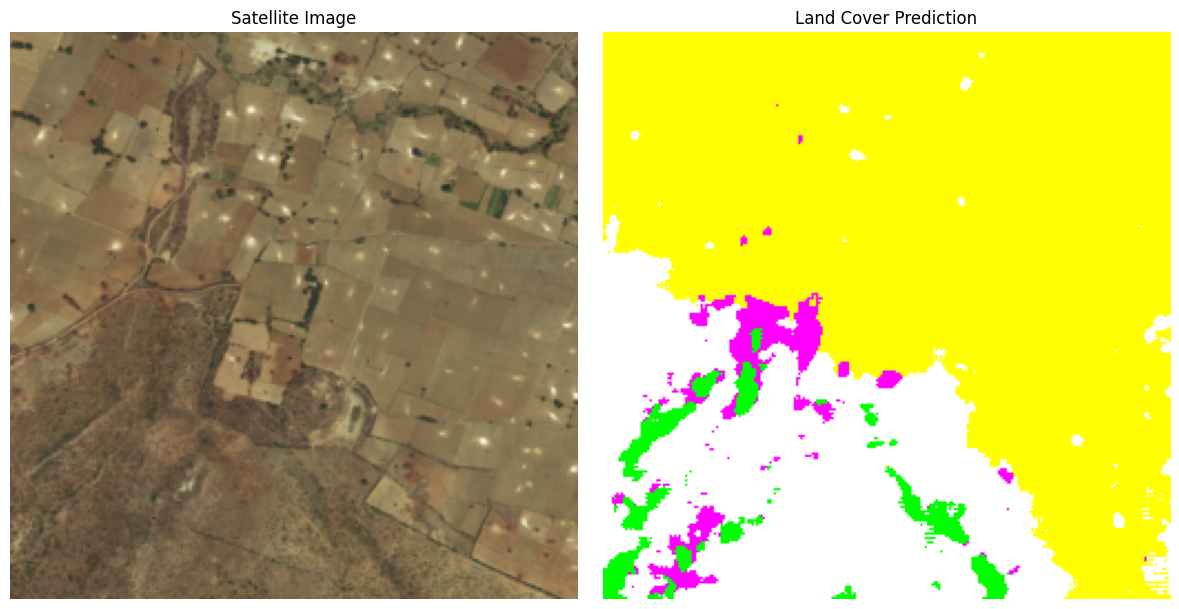

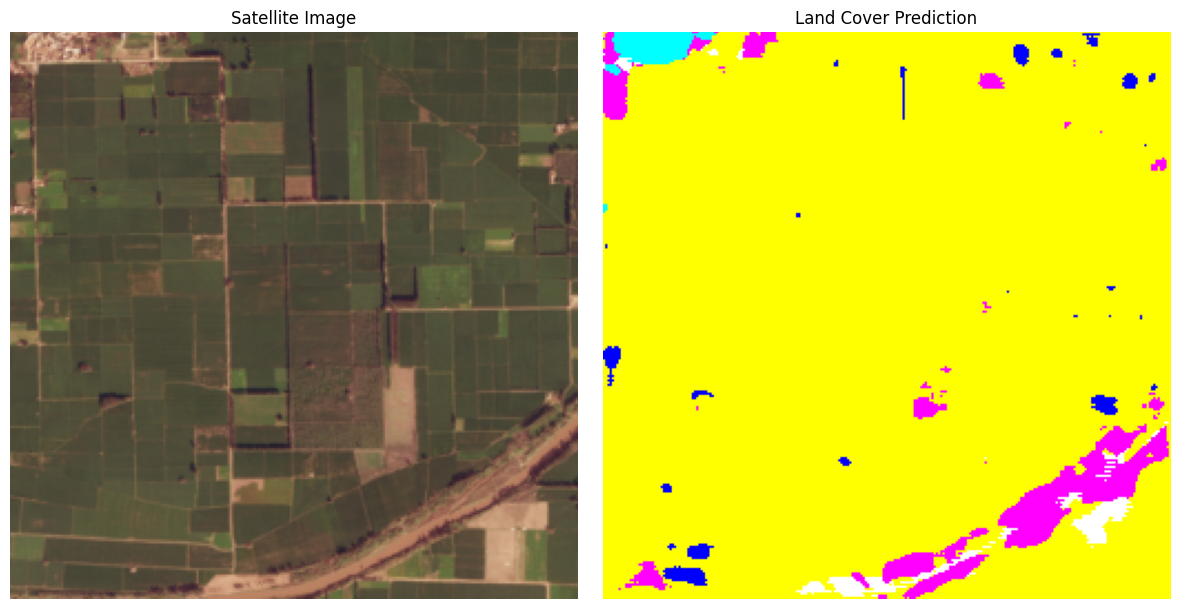

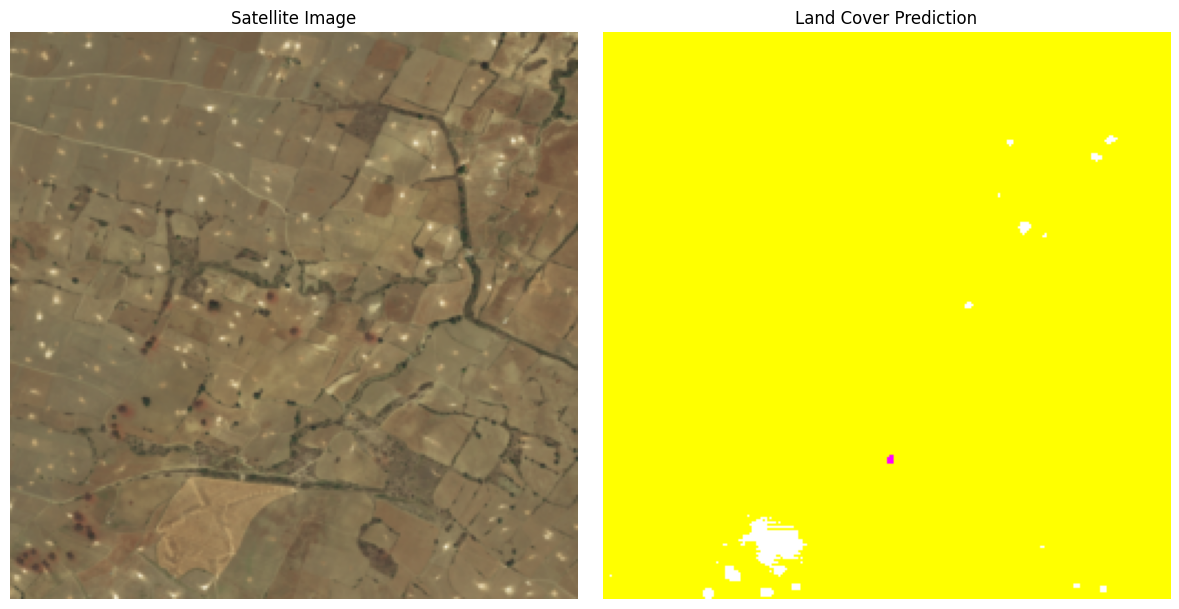

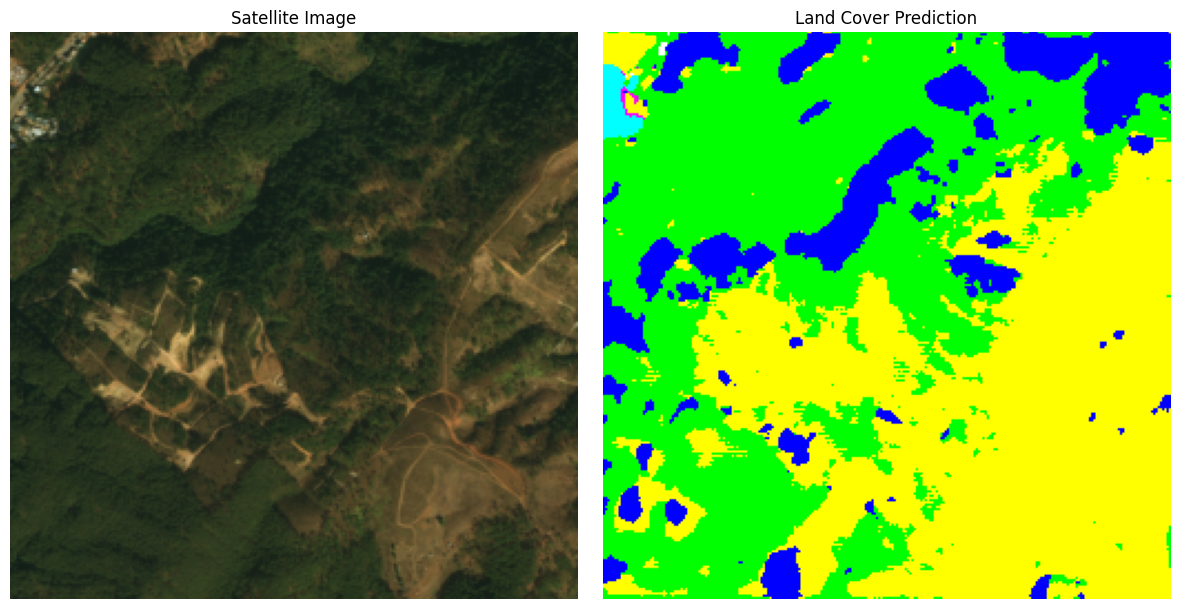

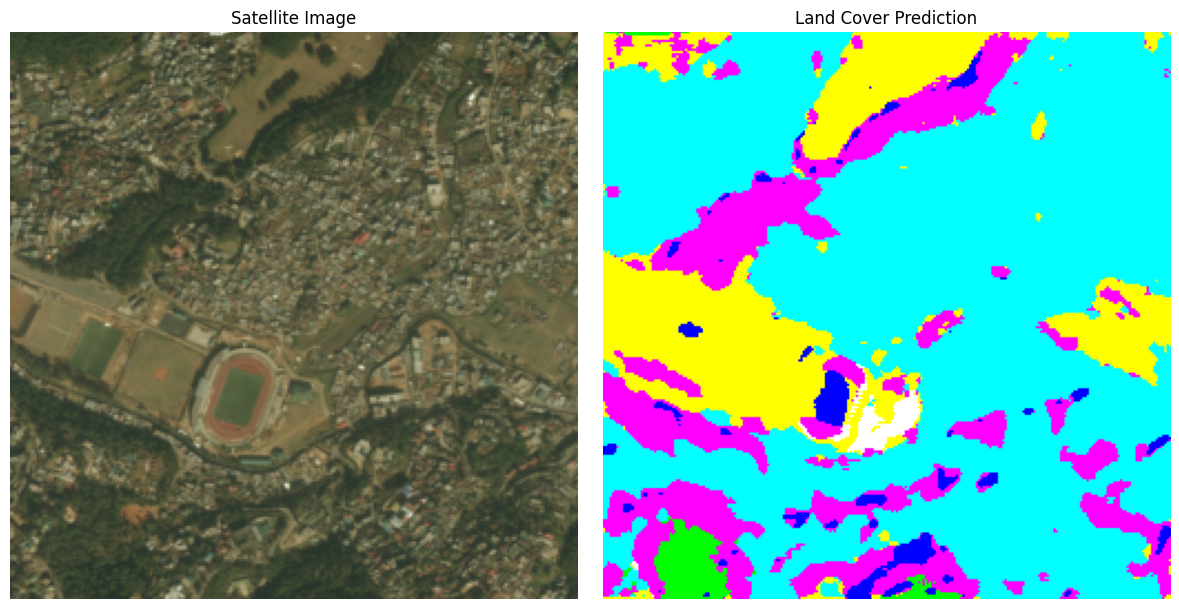

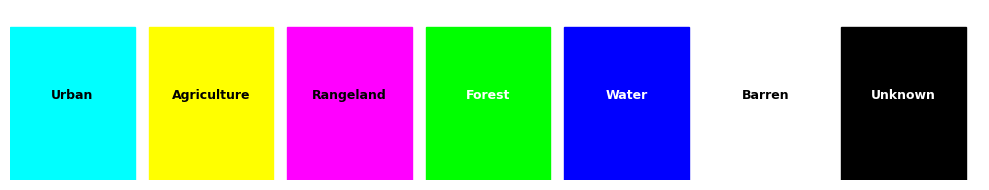

Model exported to ONNX format for deployment


In [12]:

# Load the best trained model
model.load_state_dict(torch.load('best_model.pth')['model_state_dict'])
model.eval()  # Set to evaluation mode

# Define visualization function
def visualize_prediction(model, dataset, idx, device, class_rgb_values):
    """Visualize model prediction on a single image"""
    # For validation/test dataset without ground truth
    image, img_path = dataset[idx]
    image = image.unsqueeze(0).to(device)
    
    # Get prediction
    with torch.no_grad():
        output = model(image)
        pred = torch.argmax(output, dim=1).squeeze().cpu().numpy()
    
    # Denormalize image for visualization
    image = image.squeeze().cpu().numpy().transpose(1, 2, 0)
    image = image * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
    image = np.clip(image, 0, 1)
    
    # Create colored mask for prediction
    pred_colored = np.zeros((pred.shape[0], pred.shape[1], 3), dtype=np.uint8)
    for class_idx, (r, g, b) in enumerate(class_rgb_values):
        pred_colored[pred == class_idx] = [r, g, b]
    
    # Plot
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    ax[0].imshow(image)
    ax[0].set_title('Satellite Image')
    ax[0].axis('off')
    
    ax[1].imshow(pred_colored)
    ax[1].set_title('Land Cover Prediction')
    ax[1].axis('off')
    
    plt.tight_layout()
    plt.savefig(f'prediction_{os.path.basename(img_path)}.png', dpi=300)
    
    # Calculate land cover percentages
    class_names = ["Urban", "Agriculture", "Rangeland", "Forest", "Water", "Barren", "Unknown"]
    total_pixels = pred.size
    class_pixels = {}
    
    for class_idx, name in enumerate(class_names):
        pixels = np.sum(pred == class_idx)
        percentage = (pixels / total_pixels) * 100
        class_pixels[name] = percentage
        print(f"{name}: {percentage:.2f}%")
    
    # Add classification statement based on highest percentage landform
    dominant_class = max(class_pixels, key=class_pixels.get)
    print(f"The image can be classified as {dominant_class}")
    
    return class_pixels

# Define class RGB values
class_rgb_values = [
    [0, 255, 255],     # urban_land 
    [255, 255, 0],     # agriculture_land
    [255, 0, 255],     # rangeland
    [0, 255, 0],       # forest_land
    [0, 0, 255],       # water
    [255, 255, 255],   # barren_land
    [0, 0, 0]          # unknown
]

# Evaluate on multiple validation images
def evaluate_model(model, val_loader, device, num_samples=5):
    """Evaluate model on validation data"""
    model.eval()
    
    # Create figure for multiple predictions
    fig, axes = plt.subplots(num_samples, 2, figsize=(12, 4*num_samples))
    
    with torch.no_grad():
        for i, (images, img_paths) in enumerate(val_loader):
            if i >= num_samples:
                break
                
            images = images.to(device)
            outputs = model(images)
            preds = torch.argmax(outputs, dim=1).cpu().numpy()
            
            for j, (image, pred, img_path) in enumerate(zip(images, preds, img_paths)):
                if i*val_loader.batch_size + j >= num_samples:
                    break
                    
                # Denormalize image
                image = image.cpu().numpy().transpose(1, 2, 0)
                image = image * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
                image = np.clip(image, 0, 1)
                
                # Create colored prediction
                pred_colored = np.zeros((pred.shape[0], pred.shape[1], 3), dtype=np.uint8)
                for class_idx, (r, g, b) in enumerate(class_rgb_values):
                    pred_colored[pred == class_idx] = [r, g, b]
                
                # Plot
                ax_idx = i*val_loader.batch_size + j
                axes[ax_idx, 0].imshow(image)
                axes[ax_idx, 0].set_title(f'Image {ax_idx+1}')
                axes[ax_idx, 0].axis('off')
                
                axes[ax_idx, 1].imshow(pred_colored)
                axes[ax_idx, 1].set_title(f'Prediction {ax_idx+1}')
                axes[ax_idx, 1].axis('off')
                
    plt.tight_layout()
    plt.savefig('validation_predictions.png', dpi=300)
    plt.show()

# Create a confusion matrix Legend showing the color for each class
def create_class_legend():
    class_names = ["Urban", "Agriculture", "Rangeland", "Forest", "Water", "Barren", "Unknown"]
    fig, ax = plt.subplots(figsize=(10, 2))
    ax.axis('off')
    
    for i, ((r, g, b), name) in enumerate(zip(class_rgb_values, class_names)):
        color = [r/255, g/255, b/255]
        ax.add_patch(plt.Rectangle((i, 0), 0.9, 0.9, color=color))
        ax.text(i+0.45, 0.5, name, ha='center', va='center', 
                fontsize=9, fontweight='bold', 
                color='white' if sum(color) < 1.5 else 'black')
    
    plt.xlim(0, len(class_names))
    plt.ylim(0, 1)
    plt.tight_layout()
    plt.savefig('class_legend.png', dpi=300)
    plt.show()

# Execute evaluation and visualization
print("Starting model evaluation and visualization...")
if isinstance(val_dataset[0][1], str):  # Check if val_dataset returns image paths
    # For datasets without ground truth
    for i in range(5):  # Visualize 5 random images
        idx = np.random.randint(0, len(val_dataset))
        print(f"\nVisualization {i+1}:")
        visualize_prediction(model, val_dataset, idx, device, class_rgb_values)
else:
    # For datasets with ground truth
    evaluate_model(model, val_loader, device)

# Create legend for classes
create_class_legend()

# Optional: Save the model in a deployable format (ONNX)
dummy_input = torch.randn(1, 3, 256, 256, device=device)
torch.onnx.export(model, dummy_input, "vegetation_segmentation_model.onnx", 
                 verbose=True, input_names=['input'], output_names=['output'])
print("Model exported to ONNX format for deployment")
